In [2]:
!pip install librosa soundfile numpy sklearn
!pip install SpeechRecognition
!apt-get install libasound-dev portaudio19-dev libportaudio2 libportaudiocpp0
!apt-get install ffmpeg libav-tools
!pip install pyaudio
!pip install xgboost

     |████████████████████████████████| 32.8MB 122kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libasound2-dev' instead of 'libasound-dev'
libasound2-dev is already the newest version (1.1.3-5ubuntu0.5).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 32 not upgraded.
Need to get 184 kB of archives.
After this operation, 891 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0-1 [15.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 portaudio19-dev amd64 19.6.0-1 [104 kB]
Fetched 184 kB in 1s (292 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 144467 

In [0]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from google.colab import drive
import speech_recognition as sr
import pandas as pd

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Data Link : https://zenodo.org/record/1188976#.XrBhw_IzY5k
users = ["fatih", "beyza"]
user = users[1]

if user == "fatih":
    data_folder = "/content/drive/My Drive/speech-emotion-recognition-ravdess-data"
    data_folder2 = "/content/drive/My Drive/speech-emotion-recognition-tess-data"
    test_folder = "/content/drive/My Drive/speech-emotion-recognition-test"
elif user == "beyza":
    data_folder = "/content/drive/My Drive/School/3.2/ML/speech-emotion-recognition-ravdess-data"
    data_folder2 = "/content/drive/My Drive/School/3.2/ML/speech-emotion-recognition-tess-data"
    test_folder = "/content/drive/My Drive/School/3.2/ML/sounds"
folders = os.listdir(data_folder)

In [0]:
emotions = {
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
classes = {
  'calm':'calm',
  'happy':'happy',
  'sad':'sad',
  'angry':'angry',
  'fearful':'fearful',
  'surprised':'surprised'
}

unobserved_emotions = ['neutral', 'disgust']


In [0]:
def noise(data):
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

In [0]:
def extract_feature(file_name, mfcc, mel):
  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype = "float32")          # read sound as float
    X = noise(X)
    sample_rate = sound_file.samplerate
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 30).T, axis = 0)
        result = np.hstack((result, mfccs))     # create matrix
    
    if mel:
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
  return result

In [0]:
def load_data(test_size = 0.2):
  x,y = [],[]
  for file in glob.glob(data_folder+"/Actor_*/*.wav"):
      file_name = os.path.basename(file)
      emotion = emotions[file_name.split("-")[2]]
      if emotion in unobserved_emotions:
          continue
      feature = extract_feature(file, mfcc = True, mel= False)
      x.append(feature)
      y.append(emotion)

  for file in glob.glob(data_folder2+"/*/*/*.wav"):
    file_name = os.path.basename(file)
    emotion = file_name.split("_")[0]
    if emotion in unobserved_emotions:
        continue
    feature = extract_feature(file, mfcc = True, mel=False)
    x.append(feature)
    y.append(emotion)
  return train_test_split(np.array(x), y, test_size = test_size, random_state = 9)

In [0]:
def load_data_test():
  x,y = [],[]
  for file in glob.glob(test_folder+"/*.wav"):
      file_name = os.path.basename(file)
      emotion = file_name.split("_")[0]
      if emotion in unobserved_emotions:
          continue
      feature = extract_feature(file, mfcc = True, mel= False)
      x.append(feature)
      y.append(emotion)
  return np.array(x), y

In [0]:
x_train,x_test,y_train,y_test = load_data(test_size = 0.20)

In [14]:
print((x_train.shape[0], x_test.shape[0]))
print(f'Features extracted: {x_train.shape[1]}')

(2521, 631)
Features extracted: 30


In [0]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(alpha = 0.01, batch_size = 32, hidden_layer_sizes = (64,32,32,16,8), learning_rate = 'adaptive', max_iter = 215)

In [0]:
from xgboost import XGBClassifier
xgb = XGBClassifier(colsample_bytree=0.2, gamma=0.0468, 
                             learning_rate=0.1, max_depth=4, 
                             min_child_weight=1.7817, n_estimators=100,
                             reg_alpha=0.4640, reg_lambda=1.25,
                             subsample=0.2, silent=0,
                             random_state =7, nthread = -1)

accuracy: 0.81%


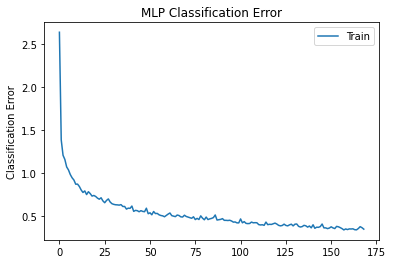

In [18]:
import matplotlib.pyplot as plt

MLP.fit(x_train, y_train)
train_pred = MLP.predict(x_test)
# evaluate predictions
accuracy = accuracy_score(y_test, train_pred)
print("accuracy: %.2f%%" % (accuracy))
#get results
x_axis = range(0, MLP.n_iter_)
fig, ax = plt.subplots()
ax.plot(x_axis, MLP.loss_curve_, label='Train')
ax.legend()
plt.ylabel('Classification Error')
plt.title('MLP Classification Error')
plt.show()

[0]	validation_0-merror:0.392701	validation_1-merror:0.394612
[1]	validation_0-merror:0.341531	validation_1-merror:0.36767
[2]	validation_0-merror:0.310194	validation_1-merror:0.326466
[3]	validation_0-merror:0.286791	validation_1-merror:0.305864
[4]	validation_0-merror:0.268148	validation_1-merror:0.290016
[5]	validation_0-merror:0.261404	validation_1-merror:0.291601
[6]	validation_0-merror:0.258231	validation_1-merror:0.285261
[7]	validation_0-merror:0.253868	validation_1-merror:0.282092
[8]	validation_0-merror:0.247917	validation_1-merror:0.280507
[9]	validation_0-merror:0.247917	validation_1-merror:0.275753
[10]	validation_0-merror:0.238794	validation_1-merror:0.264659
[11]	validation_0-merror:0.239587	validation_1-merror:0.266244
[12]	validation_0-merror:0.233241	validation_1-merror:0.259905
[13]	validation_0-merror:0.238001	validation_1-merror:0.259905
[14]	validation_0-merror:0.231257	validation_1-merror:0.25832
[15]	validation_0-merror:0.228877	validation_1-merror:0.259905
[16]

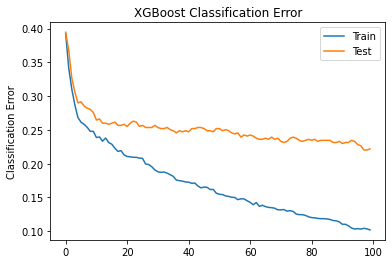

In [19]:
eval_set = [(x_train, y_train), (x_test, y_test)]
xgb.fit(x_train, y_train, eval_metric=["merror"], eval_set=eval_set, verbose=True)
train_pred = xgb.predict(x_test)
# evaluate predictions
accuracy = accuracy_score(y_test, train_pred)
print("accuracy: %.2f%%" % (accuracy))
#get results
results = xgb.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [0]:
from sklearn.ensemble import  VotingClassifier
mlpxgb = VotingClassifier(estimators=[('xgb', xgb), ('mlp', MLP)], voting='hard')
mlpxgb = mlpxgb.fit(x_train, y_train)

In [0]:
mlp_pred = MLP.predict(x_test)
xgb_pred = xgb.predict(x_test)
mlpxgb_pred = mlpxgb.predict(x_test)

In [0]:
hx_test, hy_test = load_data_test()
mlphy_pred = MLP.predict(hx_test)
xgbhy_pred = xgb.predict(hx_test)
mlpxgbhy_pred = mlpxgb.predict(hx_test)

In [23]:
accuracy = accuracy_score(y_true = hy_test, y_pred = mlphy_pred)
#Print the accuracy
print("Accuracy for MLP: {:.2f}%".format(accuracy*100))

accuracy = accuracy_score(y_true = hy_test, y_pred = xgbhy_pred)
#Print the accuracy
print("Accuracy for xgBoost: {:.2f}%".format(accuracy*100))

accuracy = accuracy_score(y_true = hy_test, y_pred = mlpxgbhy_pred)
#Print the accuracy
print("Accuracy for ensemble: {:.2f}%".format(accuracy*100))

Accuracy for MLP: 44.44%
Accuracy for xgBoost: 33.33%
Accuracy for ensemble: 44.44%


In [24]:
print("mlp: {}".format(mlphy_pred))
print("xgb: {}".format(xgbhy_pred))
print("mlpxgb: {}".format(mlpxgbhy_pred))
print("true: {}".format(hy_test))
train_xg = xgb.predict(x_train)
train_mlp = MLP.predict(x_train)
train_mlpxgb = mlpxgb.predict(x_train)

mlp: ['sad' 'angry' 'angry' 'sad' 'surprised' 'angry' 'sad' 'sad' 'angry']
xgb: ['fearful' 'angry' 'angry' 'calm' 'angry' 'angry' 'calm' 'calm' 'happy']
mlpxgb: ['fearful' 'angry' 'angry' 'calm' 'angry' 'angry' 'calm' 'calm' 'angry']
true: ['calm', 'angry', 'sad', 'sad', 'surprised', 'fearful', 'calm', 'calm', 'angry']


In [25]:
from sklearn.metrics import classification_report
# print(classification_report(y_train, train_xg, target_names=classes))
# print(classification_report(y_train, train_mlp, target_names=classes))
# print(classification_report(y_train, train_mlpxgb, target_names=classes))

print("xgb: {}".format(classification_report(y_test, xgb_pred, target_names=classes)))
print("mlp: {}".format(classification_report(y_test, mlp_pred, target_names=classes)))
print("ensemble: {}".format(classification_report(y_test, mlpxgb_pred, target_names=classes)))

xgb:               precision    recall  f1-score   support

        calm       0.77      0.86      0.81       111
       happy       0.55      0.55      0.55        38
         sad       0.83      0.86      0.85       118
       angry       0.80      0.59      0.68       124
     fearful       0.76      0.78      0.77       116
   surprised       0.80      0.89      0.84       124

    accuracy                           0.78       631
   macro avg       0.75      0.75      0.75       631
weighted avg       0.78      0.78      0.77       631

mlp:               precision    recall  f1-score   support

        calm       0.89      0.88      0.89       111
       happy       0.60      0.66      0.62        38
         sad       0.93      0.85      0.88       118
       angry       0.76      0.75      0.76       124
     fearful       0.72      0.79      0.76       116
   surprised       0.84      0.83      0.84       124

    accuracy                           0.81       631
   macro avg 

In [26]:
accuracy = accuracy_score(y_true = y_test, y_pred = mlp_pred)
#Print the accuracy
print("Accuracy for mlp: {:.2f}%".format(accuracy*100))
accuracy = accuracy_score(y_true = y_test, y_pred = xgb_pred)
#Print the accuracy
print("Accuracy for xgBoost: {:.2f}%".format(accuracy*100))
accuracy = accuracy_score(y_true = y_test, y_pred = mlpxgb_pred)
#Print the accuracy
print("Accuracy for mlpxgb: {:.2f}%".format(accuracy*100))

Accuracy for mlp: 80.98%
Accuracy for xgBoost: 77.81%
Accuracy for mlpxgb: 78.29%


In [27]:
#1D CNN
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils, to_categorical
from keras import losses, models, optimizers
from keras.activations import relu, softmax
# sklearn
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [28]:
# preparation steps to get it into the correct format for Keras 
X_train = np.array(x_train)
y_train = np.array(y_train)
X_test = np.array(x_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

(2521, 30)
['angry' 'calm' 'fearful' 'happy' 'sad' 'surprised']


In [29]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape
#Dimension preps for 1D CNN

(2521, 30, 1)

In [30]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(6)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(6)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 256)           2304      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 256)           524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 256)           1024      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 256)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 256)           

In [31]:
#train
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_test, y_test))

Train on 2521 samples, validate on 631 samples
Epoch 1/100
2521/2521 [==============================] - 13s 5ms/step - loss: 1.8010 - accuracy: 0.1765 - val_loss: 1.7931 - val_accuracy: 0.0602
Epoch 2/100
2521/2521 [==============================] - 12s 5ms/step - loss: 1.7835 - accuracy: 0.2075 - val_loss: 1.7907 - val_accuracy: 0.1426
Epoch 3/100
2521/2521 [==============================] - 12s 5ms/step - loss: 1.7703 - accuracy: 0.2495 - val_loss: 1.7892 - val_accuracy: 0.2124
Epoch 4/100
2521/2521 [==============================] - 12s 5ms/step - loss: 1.7584 - accuracy: 0.2848 - val_loss: 1.7859 - val_accuracy: 0.2345
Epoch 5/100
2521/2521 [==============================] - 12s 5ms/step - loss: 1.7448 - accuracy: 0.3106 - val_loss: 1.7825 - val_accuracy: 0.2821
Epoch 6/100
2521/2521 [==============================] - 12s 5ms/step - loss: 1.7288 - accuracy: 0.3431 - val_loss: 1.7771 - val_accuracy: 0.3296
Epoch 7/100
2521/2521 [==============================] - 12s 5ms/step - loss:

accuracy: 79.71%
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


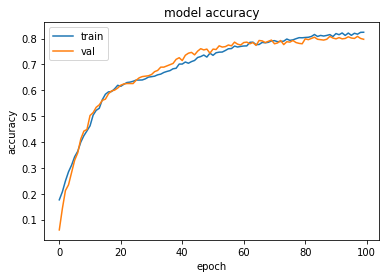

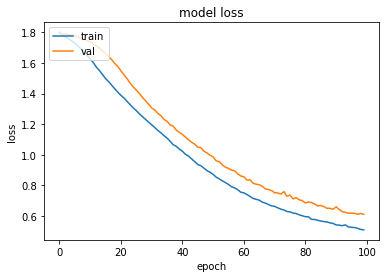

In [32]:
#predict
import matplotlib.pyplot as plt
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

print(model_history.history.keys())

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
# Save model and weights
model_name = 'Emotion_Model-1D-CNN.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/saved_models/Emotion_Model-1D-CNN.h5 


In [34]:
preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)

631/631 [==============================] - 1s 965us/step


In [0]:
# hy_test1 = np_utils.to_categorical(lb.fit_transform(hy_test))
hx_test1 = np.expand_dims(hx_test, axis=2)
hy_preds =model.predict(hx_test1)

hy_preds = hy_preds.argmax(axis=1)

In [0]:
hy_preds = hy_preds.astype(int).flatten()
hy_preds = (lb.inverse_transform((hy_preds)))
# hy_preds = (lb.inverse_transform((hy_preds)))

In [37]:
print(hy_preds)
print(hy_test)

['fearful' 'fearful' 'fearful' 'sad' 'angry' 'angry' 'fearful' 'angry'
 'angry']
['calm', 'angry', 'sad', 'sad', 'surprised', 'fearful', 'calm', 'calm', 'angry']


In [0]:
preds1 = preds.astype(int).flatten()
preds1 = (lb.inverse_transform((preds1)))
#preds1 = (lb.inverse_transform((preds1)))
actual= y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))

In [39]:
#print confusion matrix
print(classification_report(actual, preds1, target_names=classes))

              precision    recall  f1-score   support

        calm       0.77      0.92      0.84       111
       happy       0.50      0.63      0.56        38
         sad       0.91      0.86      0.89       118
       angry       0.78      0.69      0.73       124
     fearful       0.94      0.71      0.81       116
   surprised       0.76      0.87      0.81       124

    accuracy                           0.80       631
   macro avg       0.78      0.78      0.77       631
weighted avg       0.81      0.80      0.80       631

